# Tutorial Julia for Data Science

## 6 Regressione

Questa parte riguarda creazione e rappresentazione grafica di modelli di regressione in Julia.
Vedremo modelli lineari semplici, generici (logistic) e anche non lineari.

### Modelli Lineari
Vediamo tre modi per fittare un modello lineare su dei dati, prima creiamo i nostri dati (dop0o aver svolto il setup dell'ambiente).

In [16]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
using Plots
using Statistics
using StatsBase
using PyCall
using DataFrames
using GLM
using Tables
using XLSX
using MLBase
using RDatasets
using LsqFit
using DataStructures

mkpath("downloads")
mkpath("out")

 Activating environment at `C:\Users\i am\Documents\GitHub\stage-Machine-learning\notebook\tutorial\Project.toml`


"out"

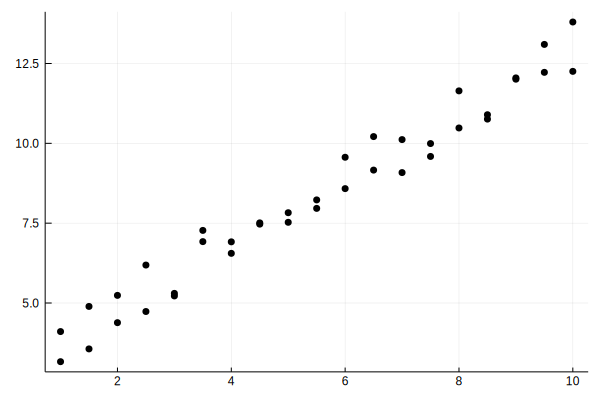

In [2]:
xvals = repeat(1:0.5:10, inner=2)
yvals = 3 .+ xvals .+ 2 .* rand(length(xvals)) .-1
scatter(xvals, yvals, color=:black, leg=false)

Abbiamo creato i nostri dati in modo che siano uno linearmente relazionato con l'altro (più un fattore di errore), perciò il grafico mostrerà relazione lineare tra i dati.

Creiamo adesso un modello lineare  $ Y = \beta_0 + \beta_1 X + \varepsilon $    
Approssimando i parametri con $$ \beta_0 \approx \hat{\beta_0} = E[Y] + \hat{\beta_1}E[X] $$
$$ \beta_1 \approx \hat{\beta_1} = \rho_{XY}\frac{\sigma_Y}{\sigma_X} $$

In [10]:
function find_best_fit(xvals,yvals)
    meanx = mean(xvals)
    meany = mean(yvals)
    stdx = std(xvals)
    stdy = std(yvals)
    r = cor(xvals,yvals)
    b1_hat = r*stdy/stdx
    b0_hat = meany - b1_hat*meanx
    return b1_hat,b0_hat
end

b1_hat,b0_hat = find_best_fit(xvals,yvals) #
y_hat = b1_hat .* xvals .+ b0_hat
resid = y_hat-yvals
MSE = mean(resid.^2)

0.29076670717633396

y_hat = { $ \hat{Y_i} : \hat{Y_i}  = \hat{\beta_0} +  \hat{\beta_1}X_i $ }  
resid = { $ e_i : e_i = Y_i - \hat{Y_i}$ }  
MSE = $ \frac1n\sum_{i=1}^{n}(Y_i - \hat{Y_i})^2 = \frac1n\sum_{i=1}^{n}(e_i)^2$ 

Vediamo un plot tra residui e predittore X per controllare se ci siano pattern su cui migliorare il modello, poi plottiamo la linea di regressione sui dati.

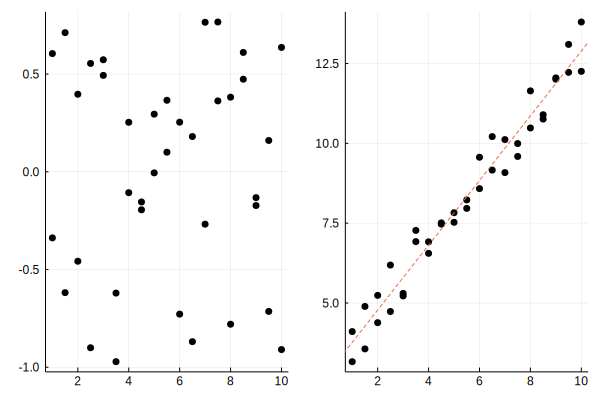

In [12]:
plot1 = scatter(xvals, resid, color=:black, leg=false)
plot2 = scatter(xvals, yvals, color=:black, leg=false)
Plots.abline!(b1_hat, b0_hat, line=:dash)
plot(plot1,plot2)

Non ci sembrano esser pattern particolari e il modello sembra fittare bene i dati.

Vediamo ora come creare un modello simile con un solo comando in Julia tramite numpy diu python:

  0.000397 seconds (45 allocations: 2.250 KiB)


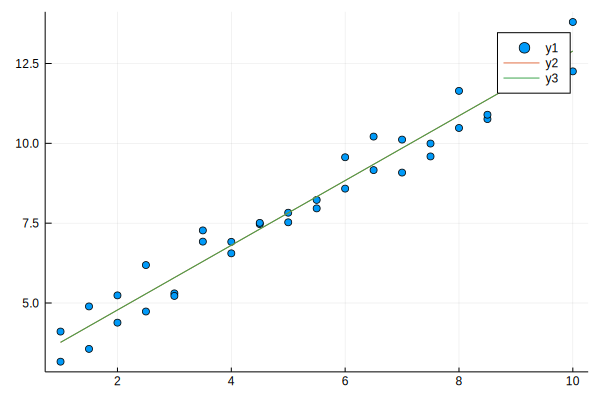

In [14]:
np = pyimport("numpy");
xdata = xvals
ydata = yvals
@time myfit = np.polyfit(xdata, ydata, 1);
ynew2 = collect(xdata) .* myfit[1] .+ myfit[2];
scatter(xvals,yvals)
plot!(xvals,y_hat)
plot!(xvals,ynew2)

Vediamo che ployfit ha creato il nostro stesso modello.

Vediamo ora lm()

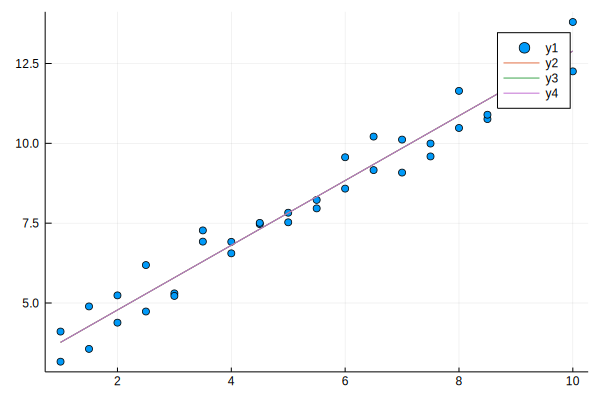

In [15]:
data = DataFrame(X=xdata, Y=ydata)
ols = lm(@formula(Y ~ X), data)
plot!(xdata,predict(ols))

I tre metodi han tutti prodotto lo stesso modello.

Vediamo ora come usare GLM.lm per creare modelli lineari di dati un pò più complessi.  
Vedremo un dataset sulle vendite di case in america divise per stato.  
Cercheremo di creare modelli, uno per ogni stato, che predicano il numero di case vendute in base al numero di case in vendita usando dati relativi a febbraio 2020. 

In [17]:
file = download("https://github.com/JuliaAcademy/DataScience/blob/master/data/zillow_data_download_april2020.xlsx?raw=true",
    "downloads/zillow_data_download_april2020.xlsx")
R = XLSX.readxlsx("downloads/zillow_data_download_april2020.xlsx")# carichiamo file excel, op lenta

"downloads/zillow_data_download_april2020.xlsx"

In [24]:
sale_counts = R["Sale_counts_city"][:]
df_sale_counts = DataFrame(sale_counts[2:end,:],Symbol.(sale_counts[1,:]))

monthly_listings = R["MonthlyListings_City"][:]
df_monthly_listings = DataFrame(monthly_listings[2:end,:],Symbol.(monthly_listings[1,:]))

monthly_listings_2020_02 = df_monthly_listings[!,[1,2,3,4,5,end]]
rename!(monthly_listings_2020_02, Symbol("2020-02") .=> Symbol("listings"))
# monthly_listings_2020_02 è df (id regione, case in vendita nel febb 2020)

sale_counts_2020_02 = df_sale_counts[!,[1,end]]
rename!(sale_counts_2020_02, Symbol("2020-02") .=> Symbol("sales"))
# sale counts 2020_02 è df (id regione, vendite nel febb 2020)

Feb2020data = innerjoin(monthly_listings_2020_02,sale_counts_2020_02,on=:RegionID) #, type="outer")
#  feb2020data è df con (id regione, vendite,case in vendita)
dropmissing!(Feb2020data)#rimuoviamo dati missing
sales = Feb2020data[!,:sales]#array delle vendite
counts = Feb2020data[!,:listings]#array delle case in vendita
states = Feb2020data[!,:StateName]#array degli stati
C = counter(states)
@show C.map
countvals = values(C.map)
topstates = sortperm(collect(countvals),rev=true)[1:10]
states_of_interest = collect(keys(C.map))[topstates]

,RegionID,sales
,Any,Any
1,6181,4054
2,12447,1522
3,39051,2682
4,17426,2100
5,6915,1626
6,13271,1620
7,40326,2325
8,18959,2547
9,54296,missing


In [26]:
monthly_listings_2020_02

,SizeRank,RegionID,RegionName,RegionType,StateName,listings
,Any,Any,Any,Any,Any,Any
1,1,6181,New York,City,NY,21164
2,2,12447,Los Angeles,City,CA,5553
3,3,39051,Houston,City,TX,11654
4,4,17426,Chicago,City,IL,9417
5,5,6915,San Antonio,City,TX,6887
6,6,13271,Philadelphia,City,PA,5110
7,7,40326,Phoenix,City,AZ,4419
8,8,18959,Las Vegas,City,NV,6749
9,9,54296,San Diego,City,CA,2305
